## **Multi-Env Training**
Faster then training in single environment

In [1]:
import os
import gymnasium as gym
from datetime import datetime
from stable_baselines3 import PPO, DQN
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import EvalCallback, StopTrainingOnRewardThreshold
from stable_baselines3.common.env_util import make_vec_env
from callback import SaveOnRewardThreshold
import tools

import glob, os, re, pandas as pd
import numpy as np
import random
import json

import pandas as pd
from stable_baselines3.common.vec_env import DummyVecEnv
from gymnasium.wrappers import RecordVideo
from tools import test_model, plot_result


In [2]:
# 设置日志文件夹
# Set the log folder
current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

log_path = os.path.join(os.pardir,"Training", current_time)
if not os.path.exists(log_path):
    os.makedirs(log_path)


################################################################################################
# 创建 Env
# Create the environment
vec_env = make_vec_env(env_id = "CartPole-v1", 
                       n_envs = 8, 
                       monitor_dir = os.path.join(log_path, "PPO_Original_Training_CSV")  # Create multiple environments and monitor them
                       )      


################################################################################################
# 创建 PPO Agent
# Create the PPO agent
model = PPO(policy = "MlpPolicy", 
            env = vec_env, 
            n_steps = 256,                   # ← 重点：减小 rollout 长度
            device = "cpu",                  # use device "cpu"                           # 设备类型 "cuda"， 这种情况官方建议使用 cpu
            verbose = 1,                     # Log type                                   # 日志类型
            tensorboard_log = log_path)      # Tensorboard log folder location            # Tensorboard 日志文件夹位置                  

################################################################################################
# 训练暂停的回调函数                         当奖励到达 200 就停止训练
# Callback function to stop training        Stop training when the reward reaches 500
stop_callback = StopTrainingOnRewardThreshold(reward_threshold=500, #0000FF
                                              verbose=1)

# 保存中间模型的回调函数
# Callback function to save intermediate models 
save_callback = SaveOnRewardThreshold(threshold=250,  #0000FF
                                      save_path=os.path.join(log_path))


# 训练评估的回调函数
# Callback function for training evaluation
eval_callback = EvalCallback(vec_env,
                             callback_on_new_best=stop_callback,            # 评估回调函数          # callback function for evaluation
                             best_model_save_path=log_path,                 # 最佳模型保存路径      # Best model save path
                             eval_freq=1000,                                # 每 1000 步评估一次    # Evaluate every 10000 steps
                             n_eval_episodes=20,                            # 评估 20 次            # Evaluate 20 times
                             verbose=1)

print("Log path:  ", log_path, "  \n")

################################################################################################
# 开始训练
# Start training
model.learn(total_timesteps = 50000,    #0000FF
            callback = [eval_callback,  # 添加评估回调函数 # Add evaluation callback function
                        save_callback]  # 添加保存回调函数 # Add save callback function
            )
  
# 保存模型
# Save the model
model_save_path = os.path.join(log_path, "Pi-1")
model.save(model_save_path)

Using cpu device
Log path:   ..\Training\2025-05-20_22-33-13   

Logging to ..\Training\2025-05-20_22-33-13\PPO_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 22.6     |
|    ep_rew_mean     | 22.6     |
| time/              |          |
|    fps             | 7344     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 27          |
|    ep_rew_mean          | 27          |
| time/                   |             |
|    fps                  | 2186        |
|    iterations           | 2           |
|    time_elapsed         | 1           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.009785296 |
|    clip_fraction        | 0.118       |
|    clip_range           | 0.2         |


In [3]:
# 评估模型
# Test the model
import os
import tools
PPO_Model_Path = os.path.join(log_path, "Pi-1")
tools.test_model("PPO", PPO_Model_Path, n_episodes=2, render = True)

..\Training\2025-05-20_22-33-13\Pi-1

Episode: 1 Score: 351.0
Episode: 2 Score: 500.0


Plotting path is:  ..\Training\2025-05-20_22-33-13\PPO_Original_Training_CSV


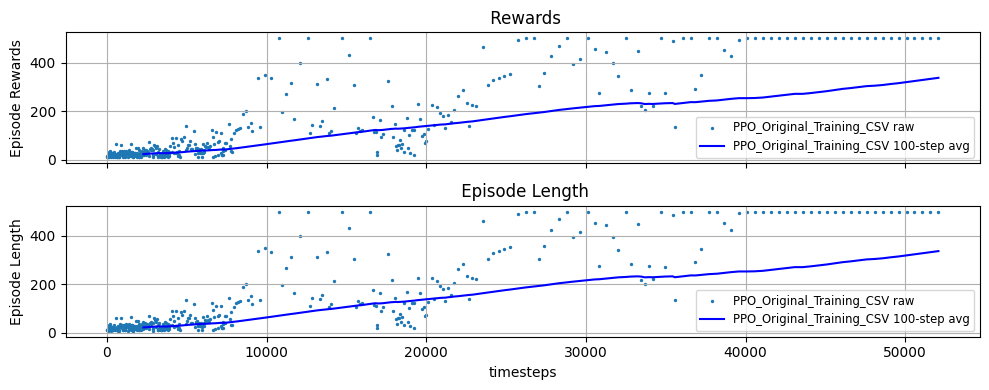

In [4]:
# 绘制结果
# Plotting the results
import tools
Monitor_CSV_path = os.path.join(log_path, "PPO_Original_Training_CSV")
print("Plotting path is: ", Monitor_CSV_path)
tools.plot_result(dirs=[Monitor_CSV_path],
                  window = 100)

# Plot Multi-Training Results
# tools.plot_result(dirs=["Training\\2025-05-04_16-23-24", "Training\\2025-05-04_16-24-35"],
#                   window = 100)

## **Generate Trajectory Pair**

In [5]:
# log_path = "Training\\2025-05-15_20-13-03"

model_pi_1_path = os.path.join(log_path, "Pi-1.zip")
model_pi_2_path = os.path.join(log_path, "Pi-2.zip")

# model_pi_1 = PPO.load(model_pi_1_path, device="cpu")
# model_pi_2 = PPO.load(model_pi_2_path, device="cpu")

tools.test_model("PPO", model_pi_1_path, n_episodes=100, render=False, record=False, traj=True)
tools.test_model("PPO", model_pi_2_path, n_episodes=100, render=False, record=False, traj=True)

tools.test_model("PPO", model_pi_1_path, n_episodes=1, render=False, record=True)
tools.test_model("PPO", model_pi_2_path, n_episodes=1, render=False, record=True)

..\Training\2025-05-20_22-33-13\Pi-1.zip

Trajectory saved to: ..\Training\2025-05-20_22-33-13\trajectory\Pi-1-trajectory-0.csv
Episode: 1 Score: 500.0
Trajectory saved to: ..\Training\2025-05-20_22-33-13\trajectory\Pi-1-trajectory-1.csv
Episode: 2 Score: 500.0
Trajectory saved to: ..\Training\2025-05-20_22-33-13\trajectory\Pi-1-trajectory-2.csv
Episode: 3 Score: 500.0
Trajectory saved to: ..\Training\2025-05-20_22-33-13\trajectory\Pi-1-trajectory-3.csv
Episode: 4 Score: 500.0
Trajectory saved to: ..\Training\2025-05-20_22-33-13\trajectory\Pi-1-trajectory-4.csv
Episode: 5 Score: 455.0
Trajectory saved to: ..\Training\2025-05-20_22-33-13\trajectory\Pi-1-trajectory-5.csv
Episode: 6 Score: 500.0
Trajectory saved to: ..\Training\2025-05-20_22-33-13\trajectory\Pi-1-trajectory-6.csv
Episode: 7 Score: 500.0
Trajectory saved to: ..\Training\2025-05-20_22-33-13\trajectory\Pi-1-trajectory-7.csv
Episode: 8 Score: 500.0
Trajectory saved to: ..\Training\2025-05-20_22-33-13\trajectory\Pi-1-trajector

c:\Users\MATH-286-Dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\gymnasium\wrappers\rendering.py:283: UserWarning: WARN: Overwriting existing videos at d:\EPFL\Course\MA2\[EE-568] Reinforcement Learning\EE-568-RL\Training\2025-05-20_22-33-13\videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(



Episode: 1 Score: 500.0
..\Training\2025-05-20_22-33-13\Pi-2.zip

Episode: 1 Score: 119.0


## **Combine Trajectories into Single File**

In [ ]:
# 测试 Test
trajectory_path = os.path.join(log_path, "trajectory")
Pi = tools.Trajectory_class(trajectory_path)

Pi.data_base_1[0]
Pi.traj_list_1[0]

# print(Pi.reward_pi_1)
# print(Pi.reward_pi_2)

print(Pi.choose_probs[0:10])
print(len(Pi.traj_prefer))
(Pi.traj_prefer[0][0:2])

RLHF_trajectory_pairs.csv 已保存到： d:\EPFL\Course\MA2\[EE-568] Reinforcement Learning\EE-568-RL\Training\2025-05-20_22-33-13
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
100


[{'state': array([ 0.04101045,  0.00522624, -0.01077586, -0.00860833]),
  'action': np.int64(1)},
 {'state': array([ 0.04111497,  0.20050105, -0.01094803, -0.30467159]),
  'action': np.int64(0)}]